In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from ipynb.fs.full.Preprocessing import preprocess
from collections import Counter


# Decision Tree Implementation

In [2]:
train_x, train_y, test_x, test_y = preprocess(100000)

In [3]:
#This one uses Counter
class Node:
    #The tree is defined with nodes that have nodes in them. The process will be implemented recursively 
    #in later parts.
    
    def __init__(self, depth=None,right_node=None, left_node=None,node_type=None,node_class = None,split_feature = None,split_threshold = None ):
        #The building block of the tree.
        #The tree is a node that have nodes...
        self.left_node = left_node
        self.right_node =right_node
        self.node_type = node_type
        self.node_class = node_class
        self.split_feature = split_feature
        self.split_threshold = split_threshold

class DecisionTree:
    def __init__(self, data=None, labels=None,max_split =500,min_member=5):
        self.max_split=max_split
        self.data = data
        self.labels = labels
        self.min_member=min_member
        self.splitnumbers = list()
    def get_class(self,labels):
        unique, counts = np.unique(labels, return_counts=True)
        counter = dict(zip(unique, counts))
        return max(labels, key=lambda x: counter[x])

    def run(self,data,labels,split_number):

        #This is the function where the recursion happens: nodes that have nodes.
       
        split_feature,split_threshold,gini = self.get_splitting_point(data,labels) #returns the feature index and the threshold
        if gini > 0 and split_number< self.max_split and len(labels) > self.min_member: #split until spliting conditions are met
            right_data, left_data,right_labels,left_labels = self.get_split(split_feature, split_threshold, data,labels)
            self.splitnumbers.append(split_number)
            right_node = self.run(data=right_data,labels = right_labels,split_number=split_number+1) 
            left_node = self.run(data = left_data,labels=left_labels,split_number=split_number+1)
            return Node(node_type = "branch",right_node = right_node, left_node = left_node,split_feature=split_feature,split_threshold=split_threshold,depth=split_number  )
        else:
            return Node(node_type = "leaf",node_class = self.get_class(labels))
    def get_splitting_point(self,data,labels):
        num_instances, num_features = np.shape(data)
        gini =np.inf
        for feature in range(num_features):
            split_threshold, gini_gain = self.best_of_feature_split(data,labels,feature)
            if gini_gain<gini:
                gini = gini_gain
                best_split_threshold , best_split_feature = split_threshold,feature
        return best_split_feature,best_split_threshold,gini 
        #return split_feature, split_threshold, gini_gain
    def best_of_feature_split(self,data,labels,split_feature):
        feature_col = data[:,split_feature]
        thresholds = np.unique(feature_col, return_counts=False) #using the values as thresholds to make it efficient
        min_gini = np.inf 
        for threshold in thresholds:
            right_data, left_data,right_labels,left_labels = self.get_split(split_feature,threshold,data,labels)
            len_right = len(right_labels)
            len_left = len(left_labels)
            gini = self.gini_index(right_labels)*(len_right/(len_right+len_left))+self.gini_index(left_labels)*(len_left/(len_right+len_left))
            if gini < min_gini:
                min_gini = gini
                split_threshold = threshold
        return split_threshold, min_gini
    def get_split(self,split_feature,split_threshold,data,labels):
        feature_col = data[:,split_feature]
        pos1 =np.where(feature_col>split_threshold)[0]
        pos2 = np.where(feature_col<=split_threshold)[0]
        right_data = data[pos1]
        left_data=data[pos2]
        left_labels=labels[pos2] 
        right_labels=labels[pos1]  
        return right_data, left_data,right_labels,left_labels   
    def fit(self):
        self.decision_maker = self.run(self.data,self.labels,0) #this returns a node instance 
    def predict(self,new_data):
        predictions = list()
        for row in new_data:
            predictions.append(self.infer(self.decision_maker,row))
        return predictions
            
    def infer(self,node,datapoint):
        if node.node_type == "branch":
            val = datapoint[node.split_feature] 
            if val > node.split_threshold:
                return self.infer(node.right_node,datapoint)
            else:
                return self.infer(node.left_node,datapoint)
        elif node.node_type == "leaf":
                return node.node_class
    def gini_index(self,labels):
        length = len(labels)

        counter = Counter(labels)
        gini = 1
        for val in counter.values():
            gini -= (val/length)**2
        return gini
    


**Training and Inference Time**

In [9]:
from time import time
data_count = 1000
Tree = DecisionTree(train_x[:data_count],train_y[:data_count],max_split =4)
t1 = time()
Tree.fit()
print(time()-t1)
full_test_label = np.concatenate((train_y[data_count:],test_y),axis=0)
full_test_data = np.concatenate((train_x[data_count:],test_x),axis=0)
predictions = Tree.predict(full_test_data)

6.18540096282959


In [11]:
count = 0
for ind,prediction in enumerate(predictions):
    if full_test_label[ind]==prediction:
        count+=1
print((count/len(predictions))*100)

94.95240315892985


**Evaluation Metrics**

In [9]:
def confusion_matrice(pred,truth,num_of_class):
    """
    Return the confusion matrix where the column indexes are predictions and 
    row indexes are ground truths.
    
    """
    confusion_mtrx=np.zeros((num_of_class,num_of_class),dtype=np.int32)
    for ind,prediction in enumerate(predictions):
        confusion_mtrx[truth[ind]][prediction]+=1
    
    #dataframe = pd.DataFrame(data=confusion_mtrx,   index=np.arange(0,num_of_class),   columns=np.arange(0,num_of_class))
    #dataframe = dataframe.style.set_caption('The Confusion Matrix ')
    #return dataframe
    return confusion_mtrx
def accuracy(pred,truth):
    count = 0

    for ind,prediction in enumerate(predictions):
        if truth[ind]==prediction:
            count+=1
    accuracy = (count/len(predictions))*100
    return accuracy


In [18]:
print(accuracy(predictions, full_test_label))
confusion_matrice(predictions, full_test_label,3)

94.99498180269867


array([[56745,  1352,   424],
       [ 2672, 16094,     3],
       [  478,     8, 20865]])

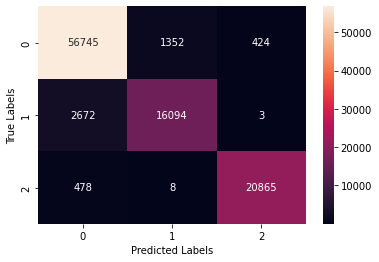

In [19]:
s = sn.heatmap(confusion_matrice(predictions, full_test_label,3), annot=True, fmt='g')
s.set(xlabel='Predicted Labels', ylabel='True Labels')
plt.show()

 **Performance Analysis**

In [578]:
Tree = DecisionTree(train_x[:1000],train_y[:1000])
from line_profiler import LineProfiler
lp = LineProfiler()
lp.enable_by_count()
lp.add_function(Tree.best_of_feature_split)
lp.add_function(Tree.get_split)
lp.add_function(Tree.get_splitting_point)
lp.add_function(Tree.run)
lp.add_function(Tree.gini_index)
lp_wrapper = lp(Tree.fit)
Tree.fit()
lp.print_stats()

Timer unit: 1e-07 s

Total time: 10.2305 s
File: C:\Users\Onat\AppData\Local\Temp/ipykernel_18724/1133872911.py
Function: build_the_tree at line 21

Line #      Hits         Time  Per Hit   % Time  Line Contents
    21                                               def build_the_tree(self,data,labels,current_depth):
    22        53        277.0      5.2      0.0          try:
    23        53       3304.0     62.3      0.0              num_instances, num_features = np.shape(data)
    24                                                   except ValueError:
    25                                                       return Node(node_type = "leaf",node_class = None)
    26        53  102260790.0 1929448.9    100.0          split_feature,split_threshold,gini = self.get_splitting_point(data,labels) #returns the feature index and the threshold
    27                                                   
    28        53        742.0     14.0      0.0          if gini > 0 and current_depth< self